In [1]:
import numpy as np
# Loading Data
labels_names =['Stadium','Building','Traffic Sign','Forest','Flowers',
              'Street','Classroom','Bridge','Statue','Lake']
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train.npy')
labels_train = labels_train.astype(int)

#train_dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train))

In [2]:
from PIL import Image
import os
import errno
#Converting data to directory
transposed_data = data_train.T

for idx, l in np.ndenumerate(labels_train):
   # data = data_train[:,idx]
    data = transposed_data[idx]
    img = Image.fromarray( data.reshape((300,300,3)), 'RGB')
    labelNr = l - 1
    filename = f'KerasPrep/{labels_names[labelNr]}/{idx[0]}.jpg'
    if not os.path.exists(os.path.dirname(filename)):
        try:
            os.makedirs(os.path.dirname(filename))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
    img.save(filename)

batch size 32
layers.RandomRotation(0.1),
layers.RandomZoom(0.1),
layers.Dropout(0.1),
randomflip: horizontal

-> Generalization 0.65


increased dropout to 0.2, added layer 128

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


def build_custom_model(batch_size, img_height, img_width, data_dir, validation_split,random_rotation,random_zoom,dropout):
    # dividing in classes train and validation 0.8 / 0.2
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    num_classes = len(train_ds.class_names)
    print(num_classes)

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=validation_split,
      subset="validation",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    #flip the images and rotate and zoom to increase generalization.
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomRotation(random_rotation),
        layers.RandomZoom(random_zoom),
      ]
    )
    # Building the sequential model with relu acitivation function
    model = Sequential([
      data_augmentation,
      layers.Rescaling(1./255),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(256, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(512, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(512, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(dropout),
      layers.Flatten(),
      layers.Dense(512, activation='relu'),
      layers.Dense(num_classes, activation = 'softmax')
    ])

    # use adam model optimizer.
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.summary()
    return model

In [47]:
batch_size = 32
img_height = 300
img_width = 300
data_dir = 'KerasPrep'
validation_split = 0.2
random_rotation = 0.4
random_zoom = 0.4
dropout = 0.4

# build model
model = build_custom_model(batch_size, img_height, img_width, data_dir, validation_split,random_rotation,random_zoom,dropout)

#train model

epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Found 3124 files belonging to 10 classes.
Using 2500 files for training.
10
Found 3124 files belonging to 10 classes.
Using 624 files for validation.
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_30 (Sequential)   (None, 300, 300, 3)       0         
_________________________________________________________________
rescaling_15 (Rescaling)     (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None,

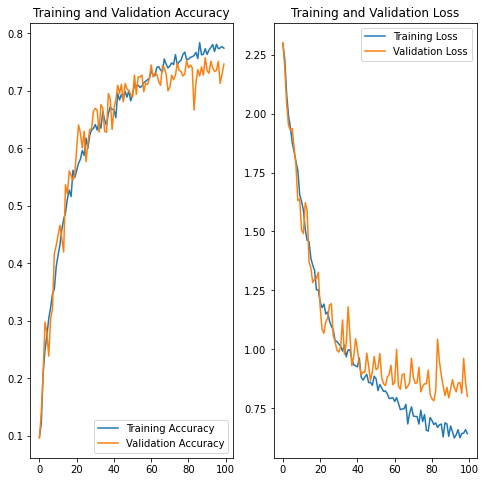

In [48]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()